# **Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error, mean_squared_error, f1_score

# **Uploading the dataset**

In [2]:
data = pd.read_csv('diabetes-2-1.csv')

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# **Exploratory data analysis**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


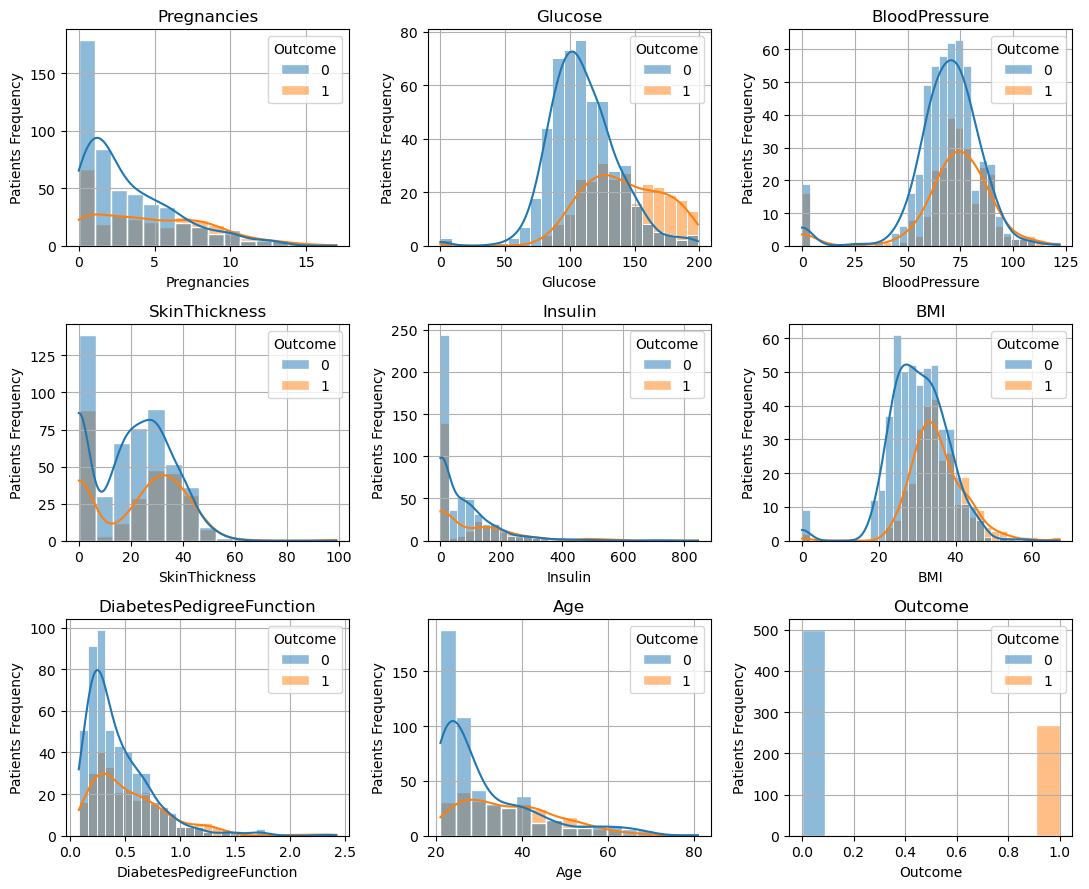

In [6]:
cols = data.columns.to_list()

# Creating 3x3 grid and iterating through the columns to plot the distributions of each variable
fig, axs = plt.subplots(3, 3, figsize=(11, 9), dpi=100)
for i, var in enumerate(cols):
    row = i // 3
    col = i % 3
    sns.histplot(data=data, x=var, kde=True, ax=axs[row, col], color="blue", edgecolor="w", hue='Outcome')
    axs[row, col].set_title(var)
    axs[row, col].set_ylabel("Patients Frequency")
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

In [7]:
corr_matrix = data.corr()

corr_matrix['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

# **Data Cleaning**

In [8]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
ser = (data == 0).sum().sort_values()

ser

DiabetesPedigreeFunction      0
Age                           0
Glucose                       5
BMI                          11
BloodPressure                35
Pregnancies                 111
SkinThickness               227
Insulin                     374
Outcome                     500
dtype: int64

In [10]:
ser.drop(['Pregnancies', 'Outcome'], inplace=True)

In [11]:
cols = ser[ser != 0].index.to_list()

data[cols] = np.where(data[cols] == 0, np.nan, data[cols])

In [12]:
def impute_val(data):
    impute = (data['mean'] - data['median']) / data['median'] * 100
    impute = np.where(impute <= 1.5, data['mean'], data['median'])
    return impute.round(2)

diabetes = data[data['Outcome'] == 1][cols].agg(['mean', 'median']).T
nondiabetes = data[data['Outcome'] == 0][cols].agg(['mean', 'median']).T

diabetes['impute'] = impute_val(diabetes)
nondiabetes['impute'] = impute_val(nondiabetes)

for col in cols:
    mask_diabetes = (data[col].isna()) & (data['Outcome'] == 1)
    mask_nondiabetes = (data[col].isna()) & (data['Outcome'] == 0)
    data.loc[mask_diabetes, col] = data.loc[mask_diabetes, col].fillna(diabetes.loc[col, 'impute'])
    data.loc[mask_nondiabetes, col] = data.loc[mask_nondiabetes, col].fillna(nondiabetes.loc[col, 'impute'])

In [13]:
(data == 0).sum().sort_values()

Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Pregnancies                 111
Outcome                     500
dtype: int64

# **Feature Engineering**

 - BMI = 0 then “NA”
 - 0 < BMI < 18.5 then “Under Weight”
 - 18.5 <= BMI < 25 then “Normal”
 - 25 <= BMI < 30 then “Overweight”
 - 30 <= BMI then “Obese”

In [14]:
# data['BMI_'] = pd.cut(data['BMI'],
#                               bins = [-float('inf'), 0, 18.5, 25, 30, float('inf')],
#                               labels = ['NA', 'Under_Weight', 'Normal', 'Overweight', 'Obese'])

- Glucose == 0 then “NA”
- Glucose < 140 then “Normal”
- 140 <= Glucose < 198 then “Impaired Glucose Tolerance”
- 198 <= Glucose then “Diabetic Level”

In [15]:
# data['Glucose_'] = pd.cut(data['Glucose'],
#                               bins = [-float('inf'), 0, 140, 198, float('inf')],
#                               labels = ['NA', 'Normal', 'Impaired_Tolerance', 'Diabetic_Level'])

In [16]:
# data = pd.get_dummies(data, drop_first=True)

# data.iloc[:, -7:] = data.iloc[:, -7:].astype('int8')

# cols = ['Pregnancies',
#         'Glucose',
#         'BloodPressure',
#         'SkinThickness',
#         'Insulin',
#         'BMI',
#         'DiabetesPedigreeFunction',
#         'Age',
#         'BMI__Under_Weight',
#         'BMI__Normal',
#         'BMI__Overweight',
#         'BMI__Obese',
#         'Glucose__Normal',
#         'Glucose__Impaired_Tolerance',
#         'Glucose__Diabetic_Level',
#         'Outcome']

# data[cols]

# **Train/Test Split**

In [17]:
X = data.drop('Outcome', axis=1)

y = data['Outcome']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# **Scaling the data**

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **Logistic Regression**

In [20]:
from sklearn.linear_model import LogisticRegression
with warnings.catch_warnings(record=True):

    model_log = LogisticRegression()
    model_log.fit(X_train, y_train)
    y_predc_log = model_log.predict(X_test)

## **Evaluating results for Logistic regresion**

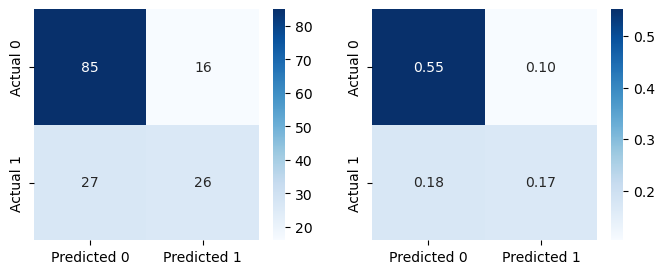

In [21]:
cm_log = confusion_matrix(y_test, y_predc_log)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[0])

sns.heatmap(cm_log/np.sum(cm_log), annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[1])

plt.show()

### **Evaluating results for Train set and Cross Validation**

In [22]:
accuracies_log = cross_val_score(model_log, X_train, y_train, cv = 10)
print("\nCross validation accuracy score: {:.2f}".format(accuracies_log.mean()))
print("Standard Deviation: {:.2f}".format(accuracies_log.std()))


Cross validation accuracy score: 0.78
Standard Deviation: 0.04


In [23]:
accuracy_score_log = accuracy_score(y_train, model_log.predict(X_train))
tn, fp, fn, tp = confusion_matrix(y_train, model_log.predict(X_train)).ravel()
specificity_log = tn / (tn + fp)
sensitivity_log = tp / (tp + fn)

log_table_train = pd.DataFrame({'Accuracy':accuracy_score_log.round(3),
                                'Specificity':specificity_log.round(3),
                                'Sensitivity':sensitivity_log.round(3)}, index=['Logistic Regression'])
log_table_train

,Accuracy,Specificity,Sensitivity
Logistic Regression,0.785,0.877,0.614


### **Evaluating results for Test set**

In [24]:
classification_report_log = classification_report(y_test, y_predc_log)

print(classification_report_log)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       101
           1       0.62      0.49      0.55        53

    accuracy                           0.72       154
   macro avg       0.69      0.67      0.67       154
weighted avg       0.71      0.72      0.71       154



In [25]:
accuracy_score_log = accuracy_score(y_test, y_predc_log)
tn, fp, fn, tp = confusion_matrix(y_test, y_predc_log).ravel()
specificity_log = tn / (tn + fp)
sensitivity_log = tp / (tp + fn)

log_table_test = pd.DataFrame({'Accuracy':accuracy_score_log.round(3),
                                'Specificity':specificity_log.round(3),
                                'Sensitivity':sensitivity_log.round(3)}, index=['Logistic Regression'])
log_table_test

,Accuracy,Specificity,Sensitivity
Logistic Regression,0.721,0.842,0.491


### **Creating summary table**

In [26]:
cols = log_table_test.columns.to_list()
columns = pd.MultiIndex.from_product([['Train', 'Test'], cols])

log_summary_table = log_table_train.merge(log_table_test, how='outer', left_index=True, right_index=True)
log_summary_table.columns = columns
log_summary_table

Train                             Test              \
                    Accuracy Specificity Sensitivity Accuracy Specificity   
Logistic Regression    0.785       0.877       0.614    0.721       0.842   

                                 
                    Sensitivity  
Logistic Regression       0.491

# **Logistic Regression with Hyperparameters**

In [27]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.linspace(0.05, 1, 1000),
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

In [28]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(model_log, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train,y_train)

Fitting 5 folds for each of 8000 candidates, totalling 40000 fits


In [29]:
best_clf.best_estimator_

LogisticRegression(C=0.06996996996996997, class_weight='balanced', penalty='l1',
                   solver='saga')

In [30]:
y_predc_hyp = best_clf.predict(X_test)

## **Evaluating results for Logistic regresion with hyperparameters tuned**

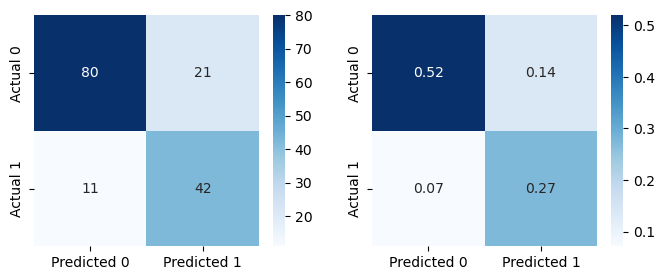

In [31]:
cm_hyp = confusion_matrix(y_test, y_predc_hyp)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(cm_hyp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[0])

sns.heatmap(cm_hyp/np.sum(cm_hyp), annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[1])

plt.show()

### **Evaluating results for Train set and Cross Validation**

In [32]:
accuracy_score_hyp = accuracy_score(y_train, best_clf.predict(X_train))
tn, fp, fn, tp = confusion_matrix(y_train, best_clf.predict(X_train)).ravel()
specificity_hyp = tn / (tn + fp)
sensitivity_hyp = tp / (tp + fn)

hyp_table_train = pd.DataFrame({'Accuracy':accuracy_score_hyp.round(3),
                                'Specificity':specificity_hyp.round(3),
                                'Sensitivity':sensitivity_hyp.round(3)}, index=['LR hyperparameter tuning'])
hyp_table_train

,Accuracy,Specificity,Sensitivity
LR hyperparameter tuning,0.795,0.812,0.763


### **Evaluating results for Test set**

In [33]:
classification_report_hyp = classification_report(y_test, y_predc_hyp)

print(classification_report_hyp)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       101
           1       0.67      0.79      0.72        53

    accuracy                           0.79       154
   macro avg       0.77      0.79      0.78       154
weighted avg       0.81      0.79      0.80       154



In [34]:
accuracy_score_hyp = accuracy_score(y_test, y_predc_hyp)
tn, fp, fn, tp = confusion_matrix(y_test, y_predc_hyp).ravel()
specificity_hyp = tn / (tn + fp)
sensitivity_hyp = tp / (tp + fn)

hyp_table_test = pd.DataFrame({'Accuracy':accuracy_score_hyp.round(3),
                                'Specificity':specificity_hyp.round(3),
                                'Sensitivity':sensitivity_hyp.round(3)}, index=['LR hyperparameter tuning'])
hyp_table_test

,Accuracy,Specificity,Sensitivity
LR hyperparameter tuning,0.792,0.792,0.792


### **Creating summary table**

In [35]:
hyp_summary_table = hyp_table_train.merge(hyp_table_test, how='outer', left_index=True, right_index=True)
hyp_summary_table.columns = columns
hyp_summary_table

Train                             Test  \
                         Accuracy Specificity Sensitivity Accuracy   
LR hyperparameter tuning    0.795       0.812       0.763    0.792   

                                                  
                         Specificity Sensitivity  
LR hyperparameter tuning       0.792       0.792

# **Decision Tree Model**

In [36]:
from sklearn.tree import DecisionTreeClassifier
with warnings.catch_warnings(record=True):
    model_tree = DecisionTreeClassifier()
    model_tree.fit(X_train, y_train)
    y_predc_tree = model_tree.predict(X_test)

## **Evaluating results for Decision Tree**

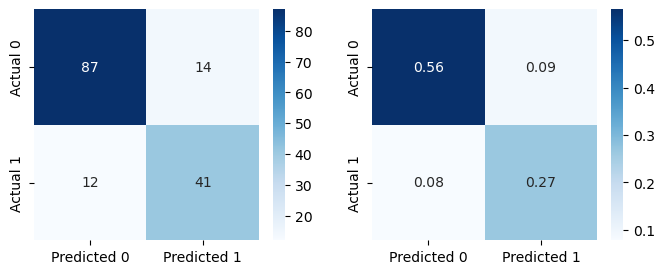

In [37]:
cm_tree = confusion_matrix(y_test, y_predc_tree)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[0])

sns.heatmap(cm_tree/np.sum(cm_tree), annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[1])

plt.show()

### **Evaluating results for Train set and Cross Validation**

In [38]:
accuracies_tree = cross_val_score(model_tree, X_train, y_train, cv = 10)
print("\nCross validation accuracy score: {:.2f}".format(accuracies_tree.mean()))
print("Standard Deviation: {:.2f}".format(accuracies_tree.std()))


Cross validation accuracy score: 0.84
Standard Deviation: 0.05


In [39]:
accuracy_score_tree = accuracy_score(y_train, model_tree.predict(X_train))
tn, fp, fn, tp = confusion_matrix(y_train, model_tree.predict(X_train)).ravel()
specificity_tree = tn / (tn + fp)
sensitivity_tree = tp / (tp + fn)

tree_table_train = pd.DataFrame({'Accuracy':accuracy_score_tree.round(3),
                                'Specificity':specificity_tree.round(3),
                                'Sensitivity':sensitivity_tree.round(3)}, index=['Decision Tree'])
tree_table_train

,Accuracy,Specificity,Sensitivity
Decision Tree,1.0,1.0,1.0


### **Evaluating results for Test set**

In [40]:
classification_report_tree = classification_report(y_test, y_predc_tree)

print(classification_report_tree)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       101
           1       0.75      0.77      0.76        53

    accuracy                           0.83       154
   macro avg       0.81      0.82      0.81       154
weighted avg       0.83      0.83      0.83       154



In [41]:
accuracy_score_tree = accuracy_score(y_test, y_predc_tree)
tn, fp, fn, tp = confusion_matrix(y_test, y_predc_tree).ravel()
specificity_tree = tn / (tn + fp)
sensitivity_tree = tp / (tp + fn)

tree_table_test = pd.DataFrame({'Accuracy':accuracy_score_tree.round(3),
                                'Specificity':specificity_tree.round(3),
                                'Sensitivity':sensitivity_tree.round(3)}, index=['Decision Tree'])
tree_table_test

,Accuracy,Specificity,Sensitivity
Decision Tree,0.831,0.861,0.774


### **Creating summary table**

In [42]:
tree_summary_table = tree_table_train.merge(tree_table_test, how='outer', left_index=True, right_index=True)
tree_summary_table.columns = columns
tree_summary_table

Train                             Test              \
              Accuracy Specificity Sensitivity Accuracy Specificity   
Decision Tree      1.0         1.0         1.0    0.831       0.861   

                           
              Sensitivity  
Decision Tree       0.774

In [43]:
fe_imp = {}

for name, importance in zip( X.columns, model_tree.feature_importances_ ):
    fe_imp[name] = importance

feature_importances = pd.Series(fe_imp).sort_values(ascending=False)

feature_importances

Insulin                     0.664544
Glucose                     0.076579
BMI                         0.072857
Age                         0.053097
Pregnancies                 0.040756
SkinThickness               0.038601
DiabetesPedigreeFunction    0.033691
BloodPressure               0.019876
dtype: float64

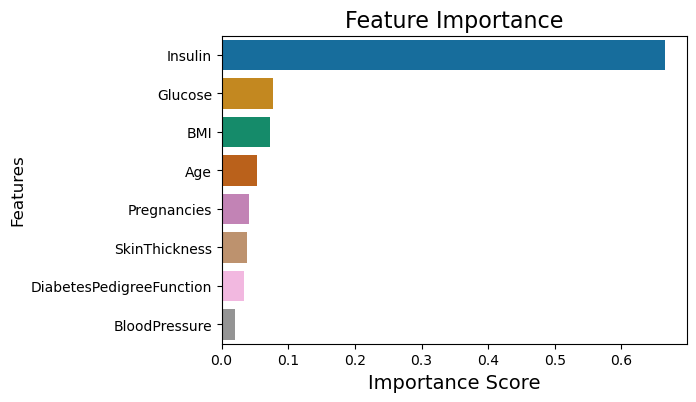

In [44]:
plt.figure(figsize=(6,4))
sns.barplot(x=feature_importances.values, 
            y=feature_importances.index,  
            palette='colorblind')

plt.xlabel('Importance Score', size=14)
plt.ylabel('Features', size=12)
plt.title('Feature Importance', size=16)

plt.show()

# **Random Forest Model**

In [45]:
from sklearn.ensemble import RandomForestClassifier
with warnings.catch_warnings(record=True):
    model_forest = RandomForestClassifier(random_state=0)
    model_forest.fit(X_train, y_train)
    y_predc_forest = model_forest.predict(X_test)

## **Evaluating results for Random Forest**

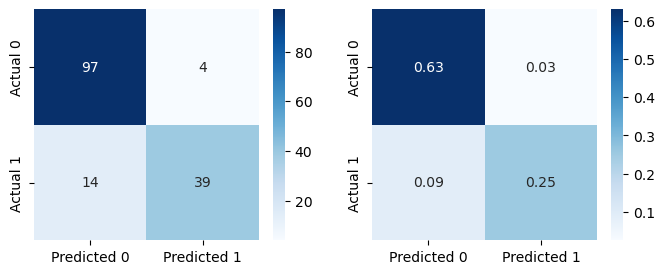

In [46]:
cm_forest = confusion_matrix(y_test, y_predc_forest)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(cm_forest, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[0])

sns.heatmap(cm_forest/np.sum(cm_forest), annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[1])

plt.show()

### **Evaluating results for Train set and Cross Validation**

In [47]:
accuracies_forest = cross_val_score(model_forest, X_train, y_train, cv = 10)
print("\nCross validation accuracy score: {:.2f}".format(accuracies_forest.mean()))
print("Standard Deviation: {:.2f}".format(accuracies_forest.std()))


Cross validation accuracy score: 0.87
Standard Deviation: 0.02


In [48]:
accuracy_score_forest = accuracy_score(y_train, model_forest.predict(X_train))
tn, fp, fn, tp = confusion_matrix(y_train, model_forest.predict(X_train)).ravel()
specificity_forest = tn / (tn + fp)
sensitivity_forest = tp / (tp + fn)

forest_table_train = pd.DataFrame({'Accuracy':accuracy_score_forest.round(3),
                                'Specificity':specificity_forest.round(3),
                                'Sensitivity':sensitivity_forest.round(3)}, index=['Random Forest'])
forest_table_train

,Accuracy,Specificity,Sensitivity
Random Forest,1.0,1.0,1.0


### **Evaluating results for Test set**

In [49]:
classification_report_forest = classification_report(y_test, y_predc_tree)

print(classification_report_forest)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       101
           1       0.75      0.77      0.76        53

    accuracy                           0.83       154
   macro avg       0.81      0.82      0.81       154
weighted avg       0.83      0.83      0.83       154



In [50]:
accuracy_score_forest = accuracy_score(y_test, y_predc_forest)
tn, fp, fn, tp = confusion_matrix(y_test, y_predc_forest).ravel()
specificity_forest = tn / (tn + fp)
sensitivity_forest = tp / (tp + fn)

forest_table_test = pd.DataFrame({'Accuracy':accuracy_score_forest.round(3),
                                'Specificity':specificity_forest.round(3),
                                'Sensitivity':sensitivity_forest.round(3)}, index=['Random Forest'])
forest_table_test

,Accuracy,Specificity,Sensitivity
Random Forest,0.883,0.96,0.736


### **Creating summary table**

In [51]:
forest_summary_table = forest_table_train.merge(forest_table_test, how='outer', left_index=True, right_index=True)
forest_summary_table.columns = columns
forest_summary_table

Train                             Test              \
              Accuracy Specificity Sensitivity Accuracy Specificity   
Random Forest      1.0         1.0         1.0    0.883        0.96   

                           
              Sensitivity  
Random Forest       0.736

In [52]:
fe_imp = {}

for name, importance in zip( X.columns, model_forest.feature_importances_ ):
    fe_imp[name] = importance

feature_importances = pd.Series(fe_imp).sort_values(ascending=False)

feature_importances

Insulin                     0.368923
SkinThickness               0.147939
Glucose                     0.136734
Age                         0.088364
BMI                         0.085855
DiabetesPedigreeFunction    0.062166
Pregnancies                 0.058092
BloodPressure               0.051925
dtype: float64

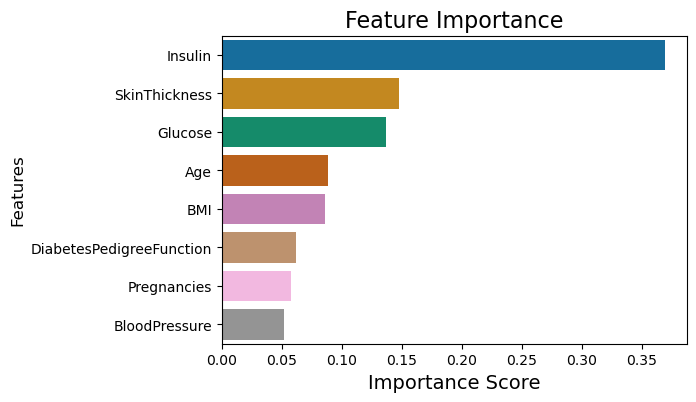

In [53]:
plt.figure(figsize=(6,4))
sns.barplot(x=feature_importances.values, 
            y=feature_importances.index,  
            palette='colorblind')

plt.xlabel('Importance Score', size=14)
plt.ylabel('Features', size=12)
plt.title('Feature Importance', size=16)

plt.show()

# **SVC**

In [54]:
from sklearn.svm import SVC
with warnings.catch_warnings(record=True):
    model_svc = SVC(kernel = 'rbf', random_state = 0)
    model_svc.fit(X_train, y_train)
    y_predc_svc = model_svc.predict(X_test)

## **Evaluating results for SVC**

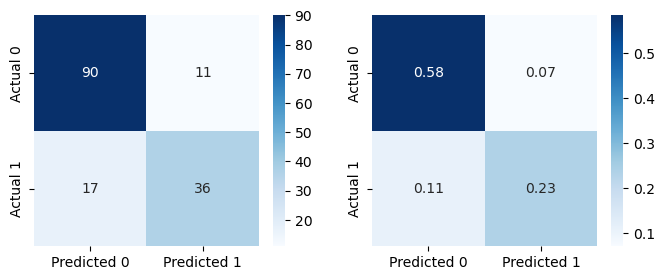

In [55]:
cm_svc = confusion_matrix(y_test, y_predc_svc)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[0])

sns.heatmap(cm_svc/np.sum(cm_svc), annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[1])

plt.show()

### **Evaluating results for Train set and Cross Validation**

In [56]:
accuracies_svc = cross_val_score(model_svc, X_train, y_train, cv = 10)
print("\nCross validation accuracy score: {:.2f}".format(accuracies_svc.mean()))
print("Standard Deviation: {:.2f}".format(accuracies_svc.std()))


Cross validation accuracy score: 0.83
Standard Deviation: 0.03


In [57]:
accuracy_score_svc = accuracy_score(y_train, model_svc.predict(X_train))
tn, fp, fn, tp = confusion_matrix(y_train, model_svc.predict(X_train)).ravel()
specificity_svc = tn / (tn + fp)
sensitivity_svc = tp / (tp + fn)

svc_table_train = pd.DataFrame({'Accuracy':accuracy_score_svc.round(3),
                                'Specificity':specificity_svc.round(3),
                                'Sensitivity':sensitivity_svc.round(3)}, index=['SVC'])
svc_table_train

,Accuracy,Specificity,Sensitivity
SVC,0.893,0.932,0.819


### **Evaluating results for Test set**

In [58]:
classification_report_svc = classification_report(y_test, y_predc_svc)

print(classification_report_svc)

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       101
           1       0.77      0.68      0.72        53

    accuracy                           0.82       154
   macro avg       0.80      0.79      0.79       154
weighted avg       0.82      0.82      0.82       154



In [59]:
accuracy_score_svc = accuracy_score(y_test, y_predc_svc)
tn, fp, fn, tp = confusion_matrix(y_test, y_predc_svc).ravel()
specificity_svc = tn / (tn + fp)
sensitivity_svc = tp / (tp + fn)

svc_table_test = pd.DataFrame({'Accuracy':accuracy_score_svc.round(3),
                                'Specificity':specificity_svc.round(3),
                                'Sensitivity':sensitivity_svc.round(3)}, index=['SVC'])
svc_table_test

,Accuracy,Specificity,Sensitivity
SVC,0.818,0.891,0.679


### **Creating summary table**

In [60]:
svc_summary_table = svc_table_train.merge(svc_table_test, how='outer', left_index=True, right_index=True)
svc_summary_table.columns = columns
svc_summary_table

Train                             Test                        
    Accuracy Specificity Sensitivity Accuracy Specificity Sensitivity
SVC    0.893       0.932       0.819    0.818       0.891       0.679

# **XG Boost**

In [61]:
# !pip install xgboost

In [62]:
import xgboost as xgb
with warnings.catch_warnings(record=True):
    model_xg = xgb.XGBClassifier()
    model_xg.fit(X_train, y_train)
    y_predc_xg = model_xg.predict(X_test)

## **Evaluating results for XGBoost**

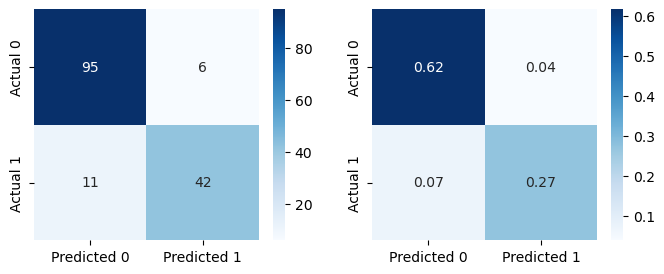

In [63]:
cm_xg = confusion_matrix(y_test, y_predc_xg)

fig, ax = plt.subplots(1, 2, figsize=(8,3))

sns.heatmap(cm_xg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[0])

sns.heatmap(cm_xg/np.sum(cm_xg), annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],cbar=True, 
            ax=ax[1])

plt.show()

### **Evaluating results for Train set and Cross Validation**

In [64]:
accuracies_xg = cross_val_score(model_xg, X_train, y_train, cv = 10)
print("\nCross validation accuracy score: {:.2f}".format(accuracies_xg.mean()))
print("Standard Deviation: {:.2f}".format(accuracies_xg.std()))


Cross validation accuracy score: 0.87
Standard Deviation: 0.03


In [65]:
accuracy_score_xg = accuracy_score(y_train, model_xg.predict(X_train))
tp, fn, fp, tn = confusion_matrix(y_train, model_xg.predict(X_train)).ravel()
specificity_xg = tn / (tn + fp)
sensitivity_xg = tp / (tp + fn)

xg_table_train = pd.DataFrame({'Accuracy':accuracy_score_xg.round(3),
                                'Specificity':specificity_xg.round(3),
                                'Sensitivity':sensitivity_xg.round(3)}, index=['XG Boost'])
xg_table_train

,Accuracy,Specificity,Sensitivity
XG Boost,1.0,1.0,1.0


### **Evaluating results for Test set**

In [66]:
classification_report_xg = classification_report(y_test, y_predc_xg)

print(classification_report_xg)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       101
           1       0.88      0.79      0.83        53

    accuracy                           0.89       154
   macro avg       0.89      0.87      0.87       154
weighted avg       0.89      0.89      0.89       154



In [67]:
accuracy_score_xg = accuracy_score(y_test, y_predc_xg)
tn, fp, fn, tp = confusion_matrix(y_test, y_predc_xg).ravel()
specificity_xg = tn / (tn + fp)
sensitivity_xg = tp / (tp + fn)

xg_table_test = pd.DataFrame({'Accuracy':accuracy_score_xg.round(3),
                                'Specificity':specificity_xg.round(3),
                                'Sensitivity':sensitivity_xg.round(3)}, index=['XG Boost'])
xg_table_test

,Accuracy,Specificity,Sensitivity
XG Boost,0.89,0.941,0.792


### **Creating summary table**

In [68]:
xg_summary_table = xg_table_train.merge(xg_table_test, how='outer', left_index=True, right_index=True)
xg_summary_table.columns = columns
xg_summary_table

Train                             Test                        
         Accuracy Specificity Sensitivity Accuracy Specificity Sensitivity
XG Boost      1.0         1.0         1.0     0.89       0.941       0.792

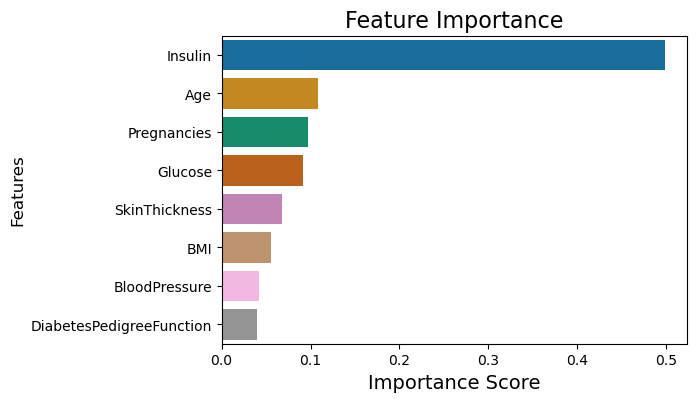

In [69]:
coef = model_xg.feature_importances_
indx = list(X.columns)
feat_ser = pd.Series(coef, index=indx)
feat_ser = feat_ser.sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=feat_ser.values, 
            y=feat_ser.index, 
            palette='colorblind',)

plt.xlabel('Importance Score', size=14)
plt.ylabel('Features', size=12)
plt.title('Feature Importance', size=16)

plt.show()

# **Summing up the results for model comparison**

In [70]:
summary_table = pd.concat([log_summary_table, hyp_summary_table, tree_summary_table, forest_summary_table, svc_summary_table, xg_summary_table])

summary_table

Train                             Test  \
                         Accuracy Specificity Sensitivity Accuracy   
Logistic Regression         0.785       0.877       0.614    0.721   
LR hyperparameter tuning    0.795       0.812       0.763    0.792   
Decision Tree               1.000       1.000       1.000    0.831   
Random Forest               1.000       1.000       1.000    0.883   
SVC                         0.893       0.932       0.819    0.818   
XG Boost                    1.000       1.000       1.000    0.890   

                                                  
                         Specificity Sensitivity  
Logistic Regression            0.842       0.491  
LR hyperparameter tuning       0.792       0.792  
Decision Tree                  0.861       0.774  
Random Forest                  0.960       0.736  
SVC                            0.891       0.679  
XG Boost                       0.941       0.792

In [71]:
f1_scores = pd.Series([f1_score(y_test, y_predc_log),
                       f1_score(y_test, y_predc_hyp),
                       f1_score(y_test, y_predc_tree),
                       f1_score(y_test, y_predc_forest),
                       f1_score(y_test, y_predc_svc),
                       f1_score(y_test, y_predc_xg)], index=summary_table.index, name='f1_score')

summary = pd.concat([summary_table['Test'], f1_scores.round(3)], axis=1)

summary

,Accuracy,Specificity,Sensitivity,f1_score
Logistic Regression,0.721,0.842,0.491,0.547
LR hyperparameter tuning,0.792,0.792,0.792,0.724
Decision Tree,0.831,0.861,0.774,0.759
Random Forest,0.883,0.960,0.736,0.812
SVC,0.818,0.891,0.679,0.720
XG Boost,0.890,0.941,0.792,0.832


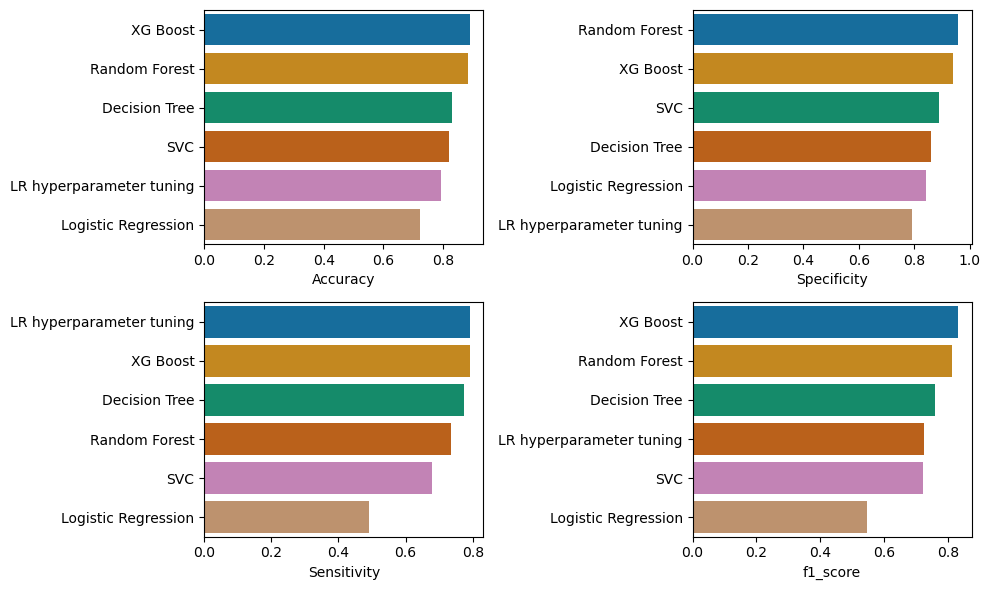

In [72]:
a = summary['Accuracy'].sort_values(ascending=False)
b = summary['Specificity'].sort_values(ascending=False)
c = summary['Sensitivity'].sort_values(ascending=False)
d = summary['f1_score'].sort_values(ascending=False)

fig, ax=plt.subplots(2,2, figsize=(10,6))
sns.barplot(y = a.index, x = a, palette='colorblind', ax=ax[0,0]);
sns.barplot(y = b.index, x = b, palette='colorblind', ax=ax[0,1])
sns.barplot(y = c.index, x = c, palette='colorblind', ax=ax[1,0])
sns.barplot(y = d.index, x = d, palette='colorblind', ax=ax[1,1])
plt.tight_layout()

# Making predictions

In [73]:
sample_data = pd.DataFrame([[5, 150, 70, 33, 170, 30, 0.5, 30],
                            [6, 135, 80, 35, 150, 40, 0.5, 40],
                            [5, 85, 90, 40, 130, 25, 1, 25],
                            [3, 190, 78, 25, 200, 30, 0.6, 35],
                            [8, 60, 70, 27, 90, 45, 2, 20]], columns=X.columns)

sample_data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,5,150,70,33,170,30,0.5,30
1,6,135,80,35,150,40,0.5,40
2,5,85,90,40,130,25,1.0,25
3,3,190,78,25,200,30,0.6,35
4,8,60,70,27,90,45,2.0,20


In [74]:
prediction = scaler.transform(sample_data)

In [75]:
sample_data['Predictions_xgboost'] = model_xg.predict(prediction)
sample_data['Predictions_random_forest'] = model_forest.predict(prediction)

In [76]:
sample_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Predictions_xgboost,Predictions_random_forest
0,5,150,70,33,170,30,0.5,30,1,1
1,6,135,80,35,150,40,0.5,40,1,1
2,5,85,90,40,130,25,1.0,25,0,0
3,3,190,78,25,200,30,0.6,35,1,1
4,8,60,70,27,90,45,2.0,20,0,0
